# Отток клиентов

Из «Гамма-Банка» усилися отток клиентов. Расчеты отдела маркетинга показали, что удержать существующих дешевле, чем привлекать новых.

Нам необходимо спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Мы располагаем историческими данными о клиентах и о том, расторгли они договор или нет. 

Мы должны создать модель с максимально большим значением *F1*-меры. Целевое значение - не ниже 0.59.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Описание данных**

Данные находятся в файле /datasets/Churn.csv (англ. «отток клиентов»).
**Признаки**

 - RowNumber — индекс строки в данных
 - CustomerId — уникальный идентификатор клиента
 - Surname — фамилия
 - CreditScore — кредитный рейтинг
 - Geography — страна проживания
 - Gender — пол
 - Age — возраст
 - Tenure — количество недвижимости у клиента
 - Balance — баланс на счёте
 - NumOfProducts — количество продуктов банка, используемых клиентом
 - HasCrCard — наличие кредитной карты
 - IsActiveMember — активность клиента
 - EstimatedSalary — предполагаемая зарплата
 
**Целевой признак**
 - Exited — факт ухода клиента

**Содержание проекта**
- [1. Подготовка данных](#1.-Подготовка-данных)
 - [1.1 Предобработка данных](#1.1-Предобработка-данных)
 - [1.2 Отбор признаков, кодирование и масштабирование](#1.2-Отбор-признаков,-кодирование-и-масштабирование)
- [2. Исследование задачи](#2.-Исследование-задачи)
- [3. Борьба с дисбалансом](#3.-Борьба-с-дисбалансом)
 - [3.1 Взвешивание классов](#3.1-Взвешивание-классов)
 - [3.2 Уменьшение выборки](#3.2-Уменьшение-выборки)
 - [3.3 Увеличение выборки](#3.3-Увеличение-выборки)
 - [3.4 Подбор гиперпараметров для лучшей модели](#3.4-Подбор-гиперпараметров-для-лучшей-модели)
- [4. Тестирование модели](#4.-Тестирование-модели)
- [Вывод](#Вывод)

# 1. Подготовка данных

### 1.1 Предобработка данных

Итак, загрузим необходимые нам инструменты и библиотеки.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix 
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

Загрузим данные.

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

Прочитаем первые пять строк.

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Посмотрим, нет ли пропусков и какие типы данных.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Видно, что в столбце 'Tenure' - количество недвижимости у клиента есть пропуски. Это единственный столбец с пропусками.

Далее взглянем на описательную статистику таблицы.

In [5]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
RowNumber,10000,NaN,NaN,NaN,5000.5,2886.9,1,2500.75,5000.5,7500.25,10000
CustomerId,10000,NaN,NaN,NaN,1.56909e+07,71936.2,1.55657e+07,1.56285e+07,1.56907e+07,1.57532e+07,1.58157e+07
Surname,10000,2932,Smith,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,10000,NaN,NaN,NaN,650.529,96.6533,350,584,652,718,850
Geography,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,10000,NaN,NaN,NaN,38.9218,10.4878,18,32,37,44,92
Tenure,9091,NaN,NaN,NaN,4.99769,2.89472,0,2,5,7,10
Balance,10000,NaN,NaN,NaN,76485.9,62397.4,0,0,97198.5,127644,250898
NumOfProducts,10000,NaN,NaN,NaN,1.5302,0.581654,1,1,1,2,4


В столбце "Пол" ошибок вроде бы нет - только 2 вида значений. Кроме того, мы рассматриваем клиентов только из трех стран.

Проверим, нет ли дубликатов.

In [6]:
dups = data[data.duplicated()]
dups

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


Дубликатов нет.

Далее поподробнее рассмотрим стобце с пропусками. Посмотрим, какие там значения и как они распределились.

In [7]:
data['Tenure'].value_counts(normalize=True)

1.0     0.104719
2.0     0.104499
8.0     0.102629
3.0     0.102079
5.0     0.101969
7.0     0.101749
4.0     0.097349
9.0     0.097019
6.0     0.096909
10.0    0.049060
0.0     0.042020
Name: Tenure, dtype: float64

Заметно, что значения количества недвижимости у клиента распределились в диапазоне от 0 до 10.

При этом на каждое значение приходится около 10% выборки, кроме 0 и 10.

Отсюда нас может навести на мысль тот факт, что пропущенные значения - это нули и десятки.

Сделаем отдельный срез по основному датафрейму с пропусками и посмотрим на их статистику, чтобы попробовать выявить закономерности. 

In [8]:
na_tenure = data[data['Tenure'].isna()]
na_tenure.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
RowNumber,909,NaN,NaN,NaN,4866.39,2909.6,31,2311,4887,7306,10000
CustomerId,909,NaN,NaN,NaN,1.56898e+07,75112.3,1.55658e+07,1.56266e+07,1.56869e+07,1.57568e+07,1.58157e+07
Surname,909,665,Hughes,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,909,NaN,NaN,NaN,648.451,99.0794,359,580,647,718,850
Geography,909,3,France,464,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,909,2,Male,483,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,909,NaN,NaN,NaN,38.648,9.78544,18,32,37,43,92
Tenure,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Balance,909,NaN,NaN,NaN,76117.3,63105.7,0,0,96674.6,128555,206664
NumOfProducts,909,NaN,NaN,NaN,1.53025,0.588452,1,1,1,2,4


In [9]:
na_tenure['Gender'].value_counts(normalize=True)

Male      0.531353
Female    0.468647
Name: Gender, dtype: float64

Мы видим, что средние значения по таким показателям, как кредитный рейтинг, возраст, баланс на счете, предполагаемая зарплата - в целом совпадают по основному датасету и срезу с пропусками. Видимо, закономерности в пропусках нет и мы не сможем заполнить их по другим данным.

Важно отметить, что баланс классов в целевом столбце 'Exited' также соответствует основному датасету.

Далее посмотрим, на распределение баланса классов в зависимости от значения Tenure.

In [10]:
for i in range(0,11):
    print (f'Баланс классов при Tenure = {i}')
    display(data[data['Tenure'] == i]['Exited'].value_counts(normalize=True))

Баланс классов при Tenure = 0


0    0.764398
1    0.235602
Name: Exited, dtype: float64

Баланс классов при Tenure = 1


0    0.776261
1    0.223739
Name: Exited, dtype: float64

Баланс классов при Tenure = 2


0    0.805263
1    0.194737
Name: Exited, dtype: float64

Баланс классов при Tenure = 3


0    0.786638
1    0.213362
Name: Exited, dtype: float64

Баланс классов при Tenure = 4


0    0.79209
1    0.20791
Name: Exited, dtype: float64

Баланс классов при Tenure = 5


0    0.798274
1    0.201726
Name: Exited, dtype: float64

Баланс классов при Tenure = 6


0    0.799092
1    0.200908
Name: Exited, dtype: float64

Баланс классов при Tenure = 7


0    0.827027
1    0.172973
Name: Exited, dtype: float64

Баланс классов при Tenure = 8


0    0.813505
1    0.186495
Name: Exited, dtype: float64

Баланс классов при Tenure = 9


0    0.780045
1    0.219955
Name: Exited, dtype: float64

Баланс классов при Tenure = 10


0    0.793722
1    0.206278
Name: Exited, dtype: float64

В целом заметно, что клиенты, у которых не было недвижимости, уходили немного чаще, а клиенты у которых ее было от 7 до 9 - реже. Значит, заполнение медианой может внести искажения в признаки и повредит качеству модели.

Поэтому примем решение удалить строки с пропусками.

(Изначально я пробовал заполнить медианой, но тогда точность лучшей модели получается 0.6 против 0.63, когда строки с пропусками удалены).

In [11]:
data = data.dropna(axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 14 columns):
RowNumber          9091 non-null int64
CustomerId         9091 non-null int64
Surname            9091 non-null object
CreditScore        9091 non-null int64
Geography          9091 non-null object
Gender             9091 non-null object
Age                9091 non-null int64
Tenure             9091 non-null float64
Balance            9091 non-null float64
NumOfProducts      9091 non-null int64
HasCrCard          9091 non-null int64
IsActiveMember     9091 non-null int64
EstimatedSalary    9091 non-null float64
Exited             9091 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.0+ MB


### 1.2 Отбор признаков, кодирование и масштабирование

Итак, начнем отбирать признаки для обучения. Во-первых, выделим целевой признак в переменную target.

In [12]:
target = data['Exited']

Затем удалим признаки, которые нам не пригодятся - индекс строки, уникальный id, фамилия, а также целевой признак. Сделаем это для новой переменной features.

In [13]:
features = data.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1)
features.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10


Затем применим прямое кодирование для преобразования категориальных признаков в количественные для получившегося датасета.

In [14]:
features = pd.get_dummies(features, drop_first=True)
features

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
9994,800,29,2.0,0.00,2,0,0,167773.55,0,0,0
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,0,0,0


Далее разделим датасет на три части - обучающую, валидационную и тестовую выборки в соотношении 3:1:1. Также сделаем стратификацию, чтобы значений целевого признака во всех выборках были равны.

Воспользуемся функцией train_test_split 2 раза.

In [15]:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, 
                                        target, test_size=0.4, random_state=1, stratify = target)

features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test, 
                        target_valid_test, test_size=0.5, random_state=1, stratify=target_valid_test)

Проверим количество объектов и баланс данных в выборках.

In [16]:
for i in [target_train, target_valid, target_test]:
    display(i.value_counts(), i.value_counts(normalize=True))

0    4342
1    1112
Name: Exited, dtype: int64

0    0.796113
1    0.203887
Name: Exited, dtype: float64

0    1447
1     371
Name: Exited, dtype: int64

0    0.79593
1    0.20407
Name: Exited, dtype: float64

0    1448
1     371
Name: Exited, dtype: int64

0    0.796042
1    0.203958
Name: Exited, dtype: float64

Во всех выборках баланс целевого класса на уровне 20.4%. Обучающая выборка содержит 6000 элементов, валидационная и тестовая - по 2000.

Далее перейдем к масштабированию количественных признаков, сначала определим их список, в него войдут:
 - кредитный рейтинг;
 - возраст;
 - количество недвижимости;
 - баланс на счете;
 - количество продуктов;
 - предполагаемая зарплата.

In [17]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Далее приступим к масштабированию.

In [18]:
scaler = StandardScaler()

In [19]:
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_valid.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
6704,-2.233539,0.557747,-0.687192,0.436989,0.820626,1,1,1.456762,1,0,1
8296,0.442200,-0.479271,0.701836,-1.239915,0.820626,1,0,1.656348,0,0,0
4696,-0.195378,0.180649,-1.728963,-1.239915,-0.919535,0,0,-0.197118,0,1,0
174,-1.439179,0.086375,0.007322,-1.239915,0.820626,1,1,0.815105,0,0,1
8156,-2.254444,3.008879,1.396350,0.680600,-0.919535,1,0,0.458497,1,0,1


Итак, мы избавились от пропусков в столбце "Количество недвижимости".

Разбили данные три выборки, провели прямое кодирование и масштабировали признаки.

На следующем этапе сделаем обучение модели без учета дисбаланса классов.

# 2. Исследование задачи

Выше мы уже этого касались, но здесь скажем еще раз: в значениях целевого признака есть дисбаланс классов - около 20% приходится на положительные значения целевого класса.

Вначале определим функцию, которая будет проверять метрики классификации разными алгоритмами на настройках по умолчанию.
Рассмотрим все метрики, которые нам известны.

In [20]:
def default_check(model_type, f_train, t_train, f_valid, t_valid):
    model = model_type(random_state=1)
    model.fit(f_train, t_train)
    model_predictions = model.predict(f_valid)
    probabilities_valid = model.predict_proba(f_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    print(f'Модель: {model_type}')
    print(f'Accuracy :{accuracy_score(t_valid, model_predictions):.3f}')
    print(f'Точность: {precision_score(t_valid, model_predictions):.3f}')
    print(f'Полнота: {recall_score(t_valid, model_predictions):.3f}')
    print(f'F1: {f1_score(t_valid, model_predictions):.3f}')
    print(f'AUC-ROC: {roc_auc_score(t_valid, probabilities_one_valid):.3f}')
    print('Матрица ошибок')
    display(confusion_matrix(t_valid, model_predictions))
    print('-'*30)

Затем применим эту функцию для трех известных нам алгоритмов - дерева решений, случайного леса и логистической регрессии.

Переберем значения в цикле.

In [21]:
for i in [DecisionTreeClassifier, RandomForestClassifier, LogisticRegression]:
    default_check(i, features_train, target_train, features_valid, target_valid)

Модель: <class 'sklearn.tree.tree.DecisionTreeClassifier'>
Accuracy :0.792
Точность: 0.489
Полнота: 0.466
F1: 0.477
AUC-ROC: 0.671
Матрица ошибок


array([[1266,  181],
       [ 198,  173]])

------------------------------
Модель: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Accuracy :0.848
Точность: 0.709
Полнота: 0.434
F1: 0.538
AUC-ROC: 0.830
Матрица ошибок


array([[1381,   66],
       [ 210,  161]])

------------------------------
Модель: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Accuracy :0.816
Точность: 0.661
Полнота: 0.205
F1: 0.313
AUC-ROC: 0.789
Матрица ошибок


array([[1408,   39],
       [ 295,   76]])

------------------------------


Получилось, что интересующая нас более всего F1-мера является наиболее высокой у случайного леса, составляя 0.54.

При этом видно, что лес имеет меньшую величину TP-ответов (истинно-положительных) и большую величину FN-ответов, по сравнению с решающим деревом. Этим обусловлена более высокая полнота решающего дерева. 

Но у дерева очень много FP-ответов (ложноположительных), что приводит к его низкой точности. У леса наблюдается иная картина.

Модель, обученная логистической регрессией очень часто выдает нули, что приводит к тому, что у нее самое большое количество TN-ответов, но также больше всех FN-ответов и меньше всех TP-ответов. Как следствие, полнота является худшей.

# 3. Борьба с дисбалансом

### 3.1 Взвешивание классов

Итак, нам известно, что в наших данных есть дисбаланс. Попробуем это учесть, сделав взвешивание классов - добавим параметр class_weight = 'balanced в настройки наших алгоритмов.

In [22]:
def default_check_balanced(model_type, f_train, t_train, f_valid, t_valid):
    model = model_type(random_state=1, class_weight = 'balanced')
    model.fit(f_train, t_train)
    model_predictions = model.predict(f_valid)
    probabilities_valid = model.predict_proba(f_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    print(f'Модель: {model_type}')
    print(f'Accuracy :{accuracy_score(t_valid, model_predictions):.3f}')
    print(f'Точность: {precision_score(t_valid, model_predictions):.3f}')
    print(f'Полнота: {recall_score(t_valid, model_predictions):.3f}')
    print(f'F1: {f1_score(t_valid, model_predictions):.3f}')
    print(f'AUC-ROC: {roc_auc_score(t_valid, probabilities_one_valid):.3f}')
    print('Матрица ошибок')
    display(confusion_matrix(t_valid, model_predictions))
    print('-'*30)

In [23]:
for i in [DecisionTreeClassifier, RandomForestClassifier, LogisticRegression]:
    default_check_balanced(i, features_train, target_train, features_valid, target_valid)

Модель: <class 'sklearn.tree.tree.DecisionTreeClassifier'>
Accuracy :0.805
Точность: 0.524
Полнота: 0.464
F1: 0.492
AUC-ROC: 0.678
Матрица ошибок


array([[1291,  156],
       [ 199,  172]])

------------------------------
Модель: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Accuracy :0.850
Точность: 0.753
Полнота: 0.394
F1: 0.517
AUC-ROC: 0.817
Матрица ошибок


array([[1399,   48],
       [ 225,  146]])

------------------------------
Модель: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Accuracy :0.741
Точность: 0.420
Полнота: 0.706
F1: 0.527
AUC-ROC: 0.793
Матрица ошибок


array([[1085,  362],
       [ 109,  262]])

------------------------------


Мы увидели, что F1 дерева решений выросла, а случайного леса незначительно снизилась.

И стремительно выросла F1-мера логистической регрессии, опередив метрику случайного леса. Логистическая регрессия стала более щедро предсказывать положительные значения целевого класса, что привело к увеличению полноты, но снижению точности.

Однако метрика AUC-ROC все-таки выше у случайного леса.

### 3.2 Уменьшение выборки 

Поскольку мы не достигли целевого значения F1-меры в 0.59, продолжим бороться с дисбалансом и уменьшим выборку, отбросив часть отрицательных объектов.

Для этого напишем функцию уменьшения выборки.

In [24]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=1)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=1)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=1)
    
    return features_downsampled, target_downsampled

Выполним уменьшение выборки и создадим нвоые переменные.

In [25]:
features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, 0.25)

In [26]:
target_train_downsampled.value_counts(normalize=True)

1    0.505914
0    0.494086
Name: Exited, dtype: float64

Как мы видим, теперь классы почти идеально сбалансированы.

Проверим наши метрики на уменьшенной выборке. Мы не используем class_weight='balanced', поскольку классы сбалансированы.

In [27]:
for i in [DecisionTreeClassifier, RandomForestClassifier, LogisticRegression]:
    default_check(i, features_train_downsampled, target_train_downsampled, features_valid, target_valid)

Модель: <class 'sklearn.tree.tree.DecisionTreeClassifier'>
Accuracy :0.707
Точность: 0.384
Полнота: 0.717
F1: 0.500
AUC-ROC: 0.711
Матрица ошибок


array([[1020,  427],
       [ 105,  266]])

------------------------------
Модель: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Accuracy :0.782
Точность: 0.477
Полнота: 0.701
F1: 0.568
AUC-ROC: 0.827
Матрица ошибок


array([[1162,  285],
       [ 111,  260]])

------------------------------
Модель: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Accuracy :0.737
Точность: 0.416
Полнота: 0.717
F1: 0.527
AUC-ROC: 0.792
Матрица ошибок


array([[1074,  373],
       [ 105,  266]])

------------------------------


Здесь мы видим, что наибольшего улучшения удалось добиться случайному лесу, при этом у него существенно изменилась матрица ошибок.

Лес пожертвовал отрицательными ответами в пользу положительных, что привело к снижению точности, но увеличению полноты. (Выросли TP и FP-ответы, а FN-снизились).

Площадь под ROC-кривой у леса продолжила расти.

Здесь мы добились прогресса, но все еще не достигли целевого значения F1-меры.

### 3.3 Увеличение выборки 

Попробуем увеличить выборку, скопировав положительные объекты целевого класса несколько раз. Напишем функцию.

In [28]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=1)
    
    return features_upsampled, target_upsampled

Сделаем увеличение выборки, создав новые переменные.

In [29]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4)

In [30]:
target_train_upsampled.value_counts(normalize=True)

1    0.50603
0    0.49397
Name: Exited, dtype: float64

Видим, что классы также почти идеально сбалансированы.

Проверим алгоритмы на увеличенной выборке.

In [31]:
for i in [DecisionTreeClassifier, RandomForestClassifier, LogisticRegression]:
    default_check(i, features_train_upsampled, target_train_upsampled, features_valid, target_valid)

Модель: <class 'sklearn.tree.tree.DecisionTreeClassifier'>
Accuracy :0.799
Точность: 0.508
Полнота: 0.442
F1: 0.473
AUC-ROC: 0.666
Матрица ошибок


array([[1288,  159],
       [ 207,  164]])

------------------------------
Модель: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Accuracy :0.842
Точность: 0.646
Полнота: 0.496
F1: 0.561
AUC-ROC: 0.830
Матрица ошибок


array([[1346,  101],
       [ 187,  184]])

------------------------------
Модель: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Accuracy :0.738
Точность: 0.417
Полнота: 0.714
F1: 0.526
AUC-ROC: 0.793
Матрица ошибок


array([[1076,  371],
       [ 106,  265]])

------------------------------


Здесь мы не видим существенной разницы в F1-мерах, по сравнению с уменьшенной выборкой, однако у случайного леса снова поменялась картина.

В отличие от уменьшенной выборки, на увеличенных данных лес снова начал показывать высокую точность, пожертвовав полнотой. AUC-ROC незначительно увеличилась, целевую F1 по-прежнему не достигли.

Поскольку F1 и AUC-ROC выше у случайного леса, продолжим дальше работать с ним, попробуем изменить гиперпараметры, чтобы повысить F1.

### 3.4 Подбор гиперпараметров для лучшей модели 

Итак, попробуем подобрать гиперпараметры для алгоритма случайного леса с целью максимизации F1 меры.

Будем менять значения глубины дерева и количества деревьев.

Модели будем обучать на увеличенной выборке, а проверять - на валидационной.

In [32]:
%%time 

best_forest_model = None
best_forest_result = 0
best_depth_for_forest = 0
best_estimators = 0

for est in range(20,101,10):
    for depth in range(3,10):
        forest_model = RandomForestClassifier(random_state=1, max_depth=depth, 
                                n_estimators=est)
            
        forest_model.fit(features_train_upsampled, target_train_upsampled)
        forest_predictions = forest_model.predict(features_valid)
        result = f1_score(target_valid, forest_predictions)
            
        if result > best_forest_result:
                
            best_forest_model = forest_model
            best_forest_result = result
            best_depth_for_forest = depth
            best_estimators = est

CPU times: user 30.4 s, sys: 23.7 ms, total: 30.4 s
Wall time: 30.7 s


In [33]:
best_forest_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [34]:
best_forest_result

0.6318234610917538

Получилось, что лучшая модель случайного леса обладает глубиной дерева равной семи, количеством деревьев равным 100.

F1-мера такой модели приблизительно равна 0.63.

Посмотрим на итоговые метрики лучшей модели случайного леса.

Создадим функцию, которая будет принимать в качестве аргументов обученную модель, признаки и целевые признаки.

Внутри нее будем рассчитывать интересующие нас метрики и построим график ROC-кривой.

In [35]:
def overall_metrics(model,f,t):

    model_predictions = model.predict(f)
    probabilities_valid = model.predict_proba(f)
    probabilities_one_valid = probabilities_valid[:, 1]

    print(f'Accuracy :{accuracy_score(t, model_predictions):.3f}')
    print(f'Точность: {precision_score(t, model_predictions):.3f}')
    print(f'Полнота: {recall_score(t, model_predictions):.3f}')
    print(f'F1: {f1_score(t, model_predictions):.3f}')
    print(f'AUC-ROC: {roc_auc_score(t, probabilities_one_valid):.3f}')
    print('Матрица ошибок')
    display(confusion_matrix(t, model_predictions))
    print('-'*30)
    
    fpr, tpr, thresholds = roc_curve(t, probabilities_one_valid)
    plt.figure()

    plt.plot(fpr, tpr)

    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC-кривая')
    plt.show()

Вызовем ее для лучшей модели случайного леса и валидационной выборки.

Accuracy :0.826
Точность: 0.555
Полнота: 0.733
F1: 0.632
AUC-ROC: 0.875
Матрица ошибок


array([[1229,  218],
       [  99,  272]])

------------------------------


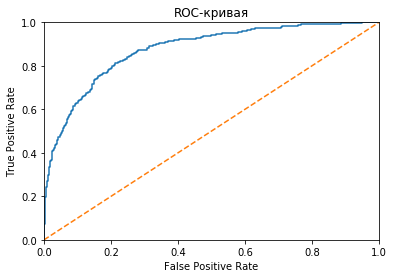

In [36]:
overall_metrics(best_forest_model, features_valid, target_valid)

Также посмотрим, как распределились значения целевого класса в нашей модели и сделаем выводы.

In [37]:
predicted_valid = pd.Series(best_forest_model.predict(features_valid))
class_frequency = predicted_valid.value_counts(normalize=True)
class_frequency

0    0.730473
1    0.269527
dtype: float64

1. Мы видим, что accuracy модели 0.826. Мы помним, что доля значений отрицательного класса в валидационной выборке находится на уровне 79.5%, значит, по сравнению с константной моделью, accuracy нашей модели выше.


2. Распределение предсказаний целевого класса показывает, что положительных объектов здесь больше, чем в валидационной выборке. Значит, у модели достаточно большое количество FP-ответов.


3. Из-за большого количества FP-ответов точность не очень высокая (0.56), но FN-ответов довольно мало, в связи с чем у модели достаточно высокая полнота (0.73).


4. Как следствие, F1 находится выше целевого уровня, составляя 0.63.


5. ROC-кривая выглядит достаточно высокой, а площаь под ней составляет 0.875.

# 4. Тестирование модели

Протестируем нашу модель на тестовой выборке.

Accuracy :0.817
Точность: 0.536
Полнота: 0.768
F1: 0.631
AUC-ROC: 0.868
Матрица ошибок


array([[1201,  247],
       [  86,  285]])

------------------------------


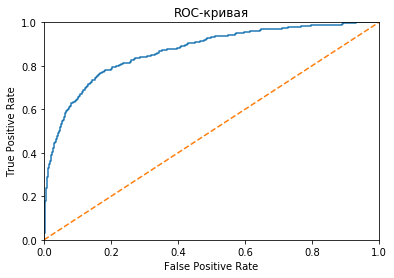

In [38]:
overall_metrics(best_forest_model, features_test, target_test)

Здесь, как мы видим, основные метрики качества, кроме полноты, снизились, но это снижение нельзя назвать значительным.

Наша модель превысила целевое значение F1-меры в 0.59.

# Вывод 

1. Мы подготовили данные к обучению - избавились от пропусков в столбце 'Количество недвижимости', удалив их (заполнение пропусков медианой приводило к меньшему значению меры F1).


2. Мы выясниили, что имеем дело с дисбалансом классов - доля положительных объектов в целевом признаке около 20%.


3. Мы разбили данные на три выборки, применив стратификацию. Соотношение выборок 3:1:1.


4. Обучение моделей алгоритмами дерево решений, случайный лес и логистическая регрессия при дисбалансе классов не позволяли претендовать на достижение целевого значения меры F1 в 0.59


5. Взвешивание классов также не решило проблему. Уменьшение выборки (отбрасыванием отрицательных значений целевого признака) и увеличение выборки (копированием положительных значений целевого признака) показало небольшой дальнейший прогресс в увеличении меры F1.


6. Мы остановились на алгоритме случайный лес, так как модели, обученные им, имели более высокие значения F1 и AUC-ROC. Подобрали гиперпараметры и обучили лучшую модель при количестве дереьвев = 100, а максимальная глубина дерева = 7. Это позволило достичь значения F1 в 0.63 на валидационной и тестовой выборках.


7. ROC - кривая расположена существенно выше случайной модели.


8. Кроме этого, наша модель прошла проверку на адекватность - ее accuracy выше, чем у константной модели (0.817 против 0.796)